# Importing packages

In [155]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import radius_graph
import enum
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

## Helper Functions

In [156]:
def decompose_graph(graph):
    # graph: torch_geometric.data.data.Data
    # TODO: make it more robust
    x, edge_index, edge_attr, global_attr = None, None, None, None
    for key in graph.keys():
        if key=="x":
            x = graph.x
        elif key=="edge_index":
            edge_index = graph.edge_index
        elif key=="edge_attr":
            edge_attr = graph.edge_attr
        elif key=="global_attr":
            global_attr = graph.global_attr
        else:
            pass
    return (x, edge_index, edge_attr, global_attr)

def copy_geometric_data(graph):
    """return a copy of torch_geometric.data.data.Data
    This function should be carefully used based on
    which keys in a given graph.
    """
    node_attr, edge_index, edge_attr, global_attr = decompose_graph(graph)
    
    ret = Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr)
    ret.global_attr = global_attr
    
    return ret

In [157]:
def build_mlp(in_size, hidden_size, out_size, lay_norm=True):

    module = nn.Sequential(nn.Linear(in_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, out_size))
    if lay_norm: return nn.Sequential(module,  nn.LayerNorm(normalized_shape=out_size))
    return module

# Blocks

In [158]:
class EdgeBlock(nn.Module):
    """ EdgeBlock, a block that updates edge attributes

    Args:
        custom_func: nn.Module, a custom function that updates edge attributes
    """

    def __init__(self, custom_func=None):
        super(EdgeBlock, self).__init__()
        self.net = custom_func

    def forward(self, graph):
        node_attr, edge_index, edge_attr, _ = decompose_graph(graph)
        senders_idx, receivers_idx = edge_index
        edges_to_collect = []

        senders_attr = node_attr[senders_idx]
        receivers_attr = node_attr[receivers_idx]

        edges_to_collect.append(senders_attr)
        edges_to_collect.append(receivers_attr)
        edges_to_collect.append(edge_attr)

        collected_edges = torch.cat(edges_to_collect, dim=1)
        
        edge_attr_ = self.net(collected_edges)   # Update

        return Data(x=node_attr, edge_attr=edge_attr_, edge_index=edge_index)

class NodeBlock(nn.Module):
    """ NodeBlock, a block that updates node attributes
    
    Args:
        custom_func: nn.Module, a custom function that updates node attributes
    """

    def __init__(self, custom_func=None):
        super(NodeBlock, self).__init__()
        self.net = custom_func

    def forward(self, graph):
        # Decompose graph
        edge_attr = graph.edge_attr
        nodes_to_collect = []
        
        _, receivers_idx = graph.edge_index
        num_nodes = graph.num_nodes
        agg_received_edges = scatter_add(edge_attr, receivers_idx, dim=0, dim_size=num_nodes)

        nodes_to_collect.append(graph.x)
        nodes_to_collect.append(agg_received_edges)
        collected_nodes = torch.cat(nodes_to_collect, dim=-1)
        x = self.net(collected_nodes)
        return Data(x=x, edge_attr=edge_attr, edge_index=graph.edge_index)

# Data

In [159]:
def create_gnn_graph(coordinates, displacement_vector, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - target (list of floats): A list of target values for each node.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    pos = torch.tensor(coordinates, dtype=torch.float)
    displacement_vector = torch.tensor(displacement_vector, dtype=torch.float).unsqueeze(1)
    
    # Add the load as a node attribute
    load = torch.rand(pos.size(0), 1) * metadata["P_initial"]

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(pos, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (pos[edge_index[1]] - pos[edge_index[0]])   
    
    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Concat node features and load
    node_features = torch.cat([pos], dim=1)
    
    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=displacement_vector)
    
    return data

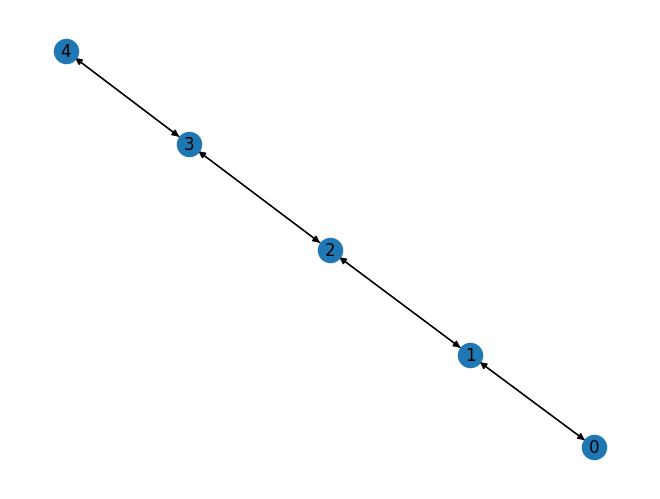

In [160]:
# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0.5,
"node_features": ["x", "y", "load"], "edge_features": ["distance", "displacement", "E_edge"],
"node_input_size": 2, "edge_input_size": 4}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
displacement = [0, 0.4, 0.5, 0.1]
graph_data = create_gnn_graph(coordinates, displacement_vector=displacement, metadata=metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()


# Encoder

In [161]:
class Encoder(nn.Module):
    """ Encoder for the graph neural network. """

    def __init__(self,
                edge_input_size=4,
                node_input_size=2,
                hidden_size=128):
        super(Encoder, self).__init__()

        self.nb_encoder = build_mlp(node_input_size, hidden_size, hidden_size)
        self.eb_encoder = build_mlp(edge_input_size, hidden_size, hidden_size)
    
    def forward(self, graph):

        node_attr, _, edge_attr, _ = decompose_graph(graph)
        node_ = self.nb_encoder(node_attr)
        edge_ = self.eb_encoder(edge_attr)
        
        return Data(x=node_, edge_attr=edge_, edge_index=graph.edge_index)

In [162]:
decompose_graph(graph_data)

(tensor([[0.5000, 0.0000],
         [1.5000, 0.0000],
         [2.5000, 0.0000],
         [3.5000, 0.0000],
         [4.5000, 0.0000]]),
 tensor([[1, 0, 2, 1, 3, 2, 4, 3],
         [0, 1, 1, 2, 2, 3, 3, 4]]),
 tensor([[ 1.0000, -1.0000,  0.0000,  2.8367],
         [ 1.0000,  1.0000,  0.0000,  8.9578],
         [ 1.0000, -1.0000,  0.0000,  0.7869],
         [ 1.0000,  1.0000,  0.0000,  7.5947],
         [ 1.0000, -1.0000,  0.0000,  6.7181],
         [ 1.0000,  1.0000,  0.0000,  9.5244],
         [ 1.0000, -1.0000,  0.0000,  7.0410],
         [ 1.0000,  1.0000,  0.0000,  7.3800]]),
 None)

In [163]:
model = Encoder(edge_input_size=4, node_input_size=2, hidden_size=128)
out1 = model(graph_data)

# Decode

In [164]:
class Decoder(nn.Module):
    """ Decoder for the GNN model. """

    def __init__(self, hidden_size=128, output_size=2):
        super(Decoder, self).__init__()
        self.decode_module = build_mlp(hidden_size, hidden_size, output_size, lay_norm=False)

    def forward(self, graph):
        return self.decode_module(graph.x)

In [165]:
model = Decoder(hidden_size=128, output_size=1)
model(out1)

tensor([[0.0911],
        [0.0852],
        [0.0762],
        [0.0717],
        [0.0729]], grad_fn=<AddmmBackward0>)

# GN Block

In [166]:
class GnBlock(nn.Module):
    """ Graph Neural Network Block """

    def __init__(self, hidden_size=128):

        super(GnBlock, self).__init__()
        eb_input_dim = 3 * hidden_size
        nb_input_dim = 2 * hidden_size
        nb_custom_func = build_mlp(nb_input_dim, hidden_size, hidden_size)
        eb_custom_func = build_mlp(eb_input_dim, hidden_size, hidden_size)
        
        self.eb_module = EdgeBlock(custom_func=eb_custom_func)
        self.nb_module = NodeBlock(custom_func=nb_custom_func)

    def forward(self, graph):
    
        graph_last = copy_geometric_data(graph)
        graph = self.eb_module(graph)
        graph = self.nb_module(graph)
        edge_attr = graph_last.edge_attr + graph.edge_attr
        x = graph_last.x + graph.x
        return Data(x=x, edge_attr=edge_attr, edge_index=graph.edge_index)

In [167]:
model = GnBlock(hidden_size=128)
model(out1)

Data(x=[5, 128], edge_index=[2, 8], edge_attr=[8, 128])

# Model

In [168]:
class EncoderProcesserDecoder(nn.Module):
    """ Encoder-Processer-Decoder model for GNN
    """

    def __init__(self, message_passing_num, node_input_size, edge_input_size, hidden_size=128):
        super(EncoderProcesserDecoder, self).__init__()
        self.encoder = Encoder(edge_input_size=edge_input_size, node_input_size=node_input_size, hidden_size=hidden_size)
        processer_list = []
        for _ in range(message_passing_num):
            processer_list.append(GnBlock(hidden_size=hidden_size))
        self.processer_list = nn.ModuleList(processer_list)
        
        self.decoder = Decoder(hidden_size=hidden_size, output_size=1)

    def forward(self, graph):

        graph= self.encoder(graph)
        for model in self.processer_list:
            graph = model(graph)
        decoded = self.decoder(graph)

        return decoded

In [169]:
model = EncoderProcesserDecoder(message_passing_num=3, node_input_size=2, edge_input_size=4, hidden_size=128)
model(graph_data)

tensor([[-0.1552],
        [-0.1471],
        [-0.1682],
        [-0.1741],
        [-0.1918]], grad_fn=<AddmmBackward0>)

# Simulator

In [181]:
class Simulator(nn.Module):
    """ Simulator model for the GNN

    Args:
        message_passing_num: int, number of message passing iterations
        node_input_size: int, size of the node input
        edge_input_size: int, size of the edge input
        device: torch.device, device to run the model
        model_dir: str, path to the model checkpoint
    """

    def __init__(self, message_passing_num, node_input_size, edge_input_size, device, model_dir='checkpoint/simulator.pth') -> None:
        super(Simulator, self).__init__()

        self.node_input_size =  node_input_size
        self.edge_input_size = edge_input_size
        self.model_dir = model_dir
        self.model = EncoderProcesserDecoder(message_passing_num=message_passing_num, node_input_size=node_input_size, edge_input_size=edge_input_size).to(device)

        print('Simulator model initialized')


    def forward(self, graph:Data):
        
        predicted = self.model(graph)
        target = graph.y

        return predicted, target

    def save(self):
        if self.model_dir is not None:
            os.makedirs(os.path.dirname(self.model_dir), exist_ok=True)
        
        torch.save(self.model.state_dict(), self.model_dir)

    def load(self):
        if self.model_dir is not None:
            self.model.load_state_dict(torch.load(self.model_dir))


In [171]:
model = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=torch.device('cpu'))
model.forward(graph_data)

Simulator model initialized


(tensor([[0.0238],
         [0.0474],
         [0.0568],
         [0.0751],
         [0.0810]], grad_fn=<AddmmBackward0>),
 tensor([[0.0000],
         [0.4000],
         [0.5000],
         [0.1000]]))

# Training

In [172]:
dataset_dir = 'dataset' 
batch_size = 20
noise_std=2e-2

print_batch = 10
save_batch = 200


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simulator = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=device)
optimizer = torch.optim.Adam(simulator.model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print('Optimizer initialized')

Simulator model initialized
Optimizer initialized


In [173]:
import torch_geometric.transforms as T
transformer = T.Compose([T.FaceToEdge(), T.Cartesian(norm=False), T.Distance(norm=False)])

In [272]:
import tqdm
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

def train(model: Simulator, dataloader, optimizer, scheduler, epochs=100, print_epoch=5, save_batch=10):
    for epoch in tqdm.tqdm(range(epochs), desc="Epochs", leave=False):
        for batch_index, graph in enumerate(tqdm.tqdm(dataloader, desc="Batches")):
            graph = graph.to(device)
            model.train()  # Ensure the model is in training mode
            pred, target = model(graph)
            loss = F.mse_loss(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update the learning rate

        if batch_index % print_batch == 0:
            print(f'Batch {batch_index}, Epoch {epoch} [Loss: {loss.item():.2e}]')

            if batch_index % save_batch == 0:
                model.save()
                print('Model saved')

            # Debugging information
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

            # Stop training if the loss is not decreasing
            if loss.item() < 1e-5:
                break

            

        


# Dataloader

In [273]:
import pandas as pd

dataset_dir = r'..\data\JSON_Data_Updated\n=100_p=1_varying_l_vectors.json'


In [312]:
# Create a class that reads the dataset_dir and creates a DataLoader object

class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, metadata):
        self.df = pd.read_json(dataset_dir)
        self.df = self.df.map(lambda x: np.array(x))
        self.df.columns = ["Displacement", "Coord", "EI"]
        self.dataset = []
        for i in range(len(self.df)):
            displacement_y = self.df["Displacement"][i]
            coordinates = self.df["Coord"][i]
            EI = self.df["EI"][i]
            graph_data = create_gnn_graph(coordinates, displacement_y, metadata)
            self.dataset.append(graph_data)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [313]:
train_dataloader = GraphDataset(dataset_dir, metadata)
test_dataloader = GraphDataset(dataset_dir, metadata)

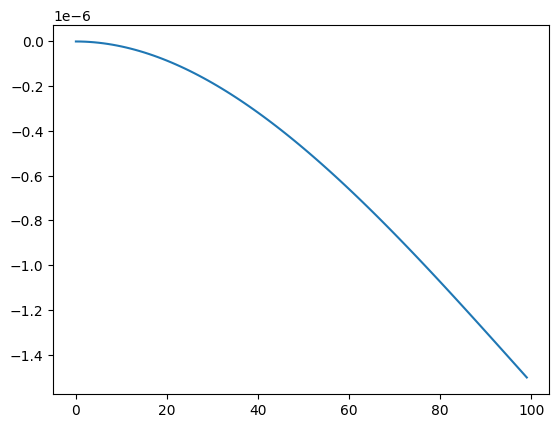

In [316]:
idx = 0
plt.plot(train_dataloader[idx].y)

# Train test

In [276]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simulator = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=device)
optimizer = torch.optim.Adam(simulator.model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Simulator model initialized


In [277]:
train(simulator, train_dataloader, optimizer, scheduler)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch 0, Epoch 0 [Loss: 1.55e-02]
Model saved
Epoch 0, Loss: 0.0155
Epoch 0, Loss: 0.0062


Epoch 0, Loss: 0.0004
Epoch 0, Loss: 0.0001
Epoch 0, Loss: 0.0003


Batch 5, Epoch 0 [Loss: 1.63e-04]
Epoch 0, Loss: 0.0002
Epoch 0, Loss: 0.0000


Epoch 0, Loss: 0.0001
Epoch 0, Loss: 0.0001


Epochs:   1%|          | 1/100 [00:01<01:42,  1.03s/it]

Epoch 0, Loss: 0.0000


Batch 0, Epoch 1 [Loss: 6.09e-05]
Model saved


Epochs:   3%|▎         | 3/100 [00:01<00:48,  2.01it/s]

Batch 0, Epoch 2 [Loss: 5.09e-05]
Model saved


Epochs:   4%|▍         | 4/100 [00:02<00:37,  2.53it/s]

Batch 0, Epoch 3 [Loss: 4.00e-05]
Model saved


Epochs:   5%|▌         | 5/100 [00:02<00:31,  3.02it/s]

Batch 0, Epoch 4 [Loss: 2.88e-05]
Model saved


Epochs:   6%|▌         | 6/100 [00:02<00:28,  3.35it/s]

Batch 0, Epoch 5 [Loss: 2.05e-05]
Model saved


Epochs:   7%|▋         | 7/100 [00:02<00:25,  3.63it/s]

Batch 0, Epoch 6 [Loss: 1.99e-05]
Model saved


Epochs:   8%|▊         | 8/100 [00:02<00:23,  3.88it/s]

Batch 0, Epoch 7 [Loss: 1.94e-05]
Model saved


Epochs:   9%|▉         | 9/100 [00:03<00:22,  4.03it/s]

Batch 0, Epoch 8 [Loss: 1.88e-05]
Model saved


Epochs:  10%|█         | 10/100 [00:03<00:21,  4.15it/s]

Batch 0, Epoch 9 [Loss: 1.84e-05]
Model saved


Epochs:  11%|█         | 11/100 [00:03<00:21,  4.24it/s]

Batch 0, Epoch 10 [Loss: 1.79e-05]
Model saved
Epoch 10, Loss: 0.0000
Epoch 10, Loss: 0.0000


Epochs:  12%|█▏        | 12/100 [00:03<00:20,  4.30it/s]

Batch 0, Epoch 11 [Loss: 1.79e-05]
Model saved


Epochs:  13%|█▎        | 13/100 [00:04<00:20,  4.29it/s]

Batch 0, Epoch 12 [Loss: 1.78e-05]
Model saved


Epochs:  14%|█▍        | 14/100 [00:04<00:19,  4.39it/s]

Batch 0, Epoch 13 [Loss: 1.78e-05]
Model saved


Batch 0, Epoch 14 [Loss: 1.77e-05]


Epochs:  15%|█▌        | 15/100 [00:04<00:19,  4.38it/s]

Model saved


Epochs:  16%|█▌        | 16/100 [00:04<00:18,  4.45it/s]

Batch 0, Epoch 15 [Loss: 1.77e-05]
Model saved


Epochs:  17%|█▋        | 17/100 [00:04<00:18,  4.53it/s]

Batch 0, Epoch 16 [Loss: 1.77e-05]
Model saved


Epochs:  18%|█▊        | 18/100 [00:05<00:18,  4.39it/s]

Batch 0, Epoch 17 [Loss: 1.77e-05]
Model saved


Epochs:  19%|█▉        | 19/100 [00:05<00:18,  4.38it/s]

Batch 0, Epoch 18 [Loss: 1.77e-05]
Model saved


Epochs:  20%|██        | 20/100 [00:05<00:19,  4.07it/s]

Batch 0, Epoch 19 [Loss: 1.77e-05]
Model saved


Epochs:  21%|██        | 21/100 [00:05<00:19,  4.14it/s]

Batch 0, Epoch 20 [Loss: 1.77e-05]
Model saved
Epoch 20, Loss: 0.0000
Epoch 20, Loss: 0.0000


Epochs:  22%|██▏       | 22/100 [00:06<00:18,  4.25it/s]

Batch 0, Epoch 21 [Loss: 1.77e-05]
Model saved


Epochs:  23%|██▎       | 23/100 [00:06<00:18,  4.23it/s]

Batch 0, Epoch 22 [Loss: 1.77e-05]
Model saved


Epochs:  24%|██▍       | 24/100 [00:06<00:17,  4.37it/s]

Batch 0, Epoch 23 [Loss: 1.77e-05]
Model saved


Epochs:  25%|██▌       | 25/100 [00:06<00:17,  4.37it/s]

Batch 0, Epoch 24 [Loss: 1.77e-05]
Model saved


Epochs:  26%|██▌       | 26/100 [00:07<00:16,  4.42it/s]

Batch 0, Epoch 25 [Loss: 1.77e-05]
Model saved


Epochs:  27%|██▋       | 27/100 [00:07<00:16,  4.39it/s]

Batch 0, Epoch 26 [Loss: 1.77e-05]
Model saved


Epochs:  28%|██▊       | 28/100 [00:07<00:15,  4.60it/s]

Batch 0, Epoch 27 [Loss: 1.77e-05]
Model saved


Batch 0, Epoch 28 [Loss: 1.77e-05]


Epochs:  29%|██▉       | 29/100 [00:07<00:15,  4.48it/s]

Model saved


Epochs:  30%|███       | 30/100 [00:07<00:15,  4.48it/s]

Batch 0, Epoch 29 [Loss: 1.77e-05]
Model saved


Epochs:  31%|███       | 31/100 [00:08<00:15,  4.54it/s]

Batch 0, Epoch 30 [Loss: 1.77e-05]
Model saved
Epoch 30, Loss: 0.0000
Epoch 30, Loss: 0.0000


Epochs:  32%|███▏      | 32/100 [00:08<00:15,  4.52it/s]

Batch 0, Epoch 31 [Loss: 1.77e-05]
Model saved


Epochs:  33%|███▎      | 33/100 [00:08<00:16,  4.19it/s]

Batch 0, Epoch 32 [Loss: 1.77e-05]
Model saved


Epochs:  34%|███▍      | 34/100 [00:08<00:15,  4.23it/s]

Batch 0, Epoch 33 [Loss: 1.77e-05]
Model saved


Epochs:  35%|███▌      | 35/100 [00:09<00:15,  4.25it/s]

Batch 0, Epoch 34 [Loss: 1.77e-05]
Model saved


Epochs:  36%|███▌      | 36/100 [00:09<00:14,  4.30it/s]

Batch 0, Epoch 35 [Loss: 1.77e-05]
Model saved


Epochs:  37%|███▋      | 37/100 [00:09<00:14,  4.33it/s]

Batch 0, Epoch 36 [Loss: 1.77e-05]
Model saved


Epochs:  38%|███▊      | 38/100 [00:09<00:13,  4.49it/s]

Batch 0, Epoch 37 [Loss: 1.77e-05]
Model saved


Epochs:  39%|███▉      | 39/100 [00:09<00:13,  4.42it/s]

Batch 0, Epoch 38 [Loss: 1.77e-05]
Model saved


Epochs:  40%|████      | 40/100 [00:10<00:13,  4.50it/s]

Batch 0, Epoch 39 [Loss: 1.77e-05]
Model saved


Epochs:  41%|████      | 41/100 [00:10<00:13,  4.42it/s]

Batch 0, Epoch 40 [Loss: 1.77e-05]
Model saved
Epoch 40, Loss: 0.0000
Epoch 40, Loss: 0.0000


Epochs:  42%|████▏     | 42/100 [00:10<00:12,  4.47it/s]

Batch 0, Epoch 41 [Loss: 1.77e-05]
Model saved


Epochs:  43%|████▎     | 43/100 [00:10<00:12,  4.51it/s]

Batch 0, Epoch 42 [Loss: 1.77e-05]
Model saved


Epochs:  44%|████▍     | 44/100 [00:11<00:12,  4.33it/s]

Batch 0, Epoch 43 [Loss: 1.77e-05]
Model saved


Epochs:  45%|████▌     | 45/100 [00:11<00:13,  4.22it/s]

Batch 0, Epoch 44 [Loss: 1.77e-05]
Model saved


Epochs:  46%|████▌     | 46/100 [00:11<00:12,  4.31it/s]

Batch 0, Epoch 45 [Loss: 1.77e-05]
Model saved


Epochs:  47%|████▋     | 47/100 [00:11<00:12,  4.40it/s]

Batch 0, Epoch 46 [Loss: 1.77e-05]
Model saved


Epochs:  48%|████▊     | 48/100 [00:12<00:12,  4.27it/s]

Batch 0, Epoch 47 [Loss: 1.77e-05]
Model saved


Epochs:  49%|████▉     | 49/100 [00:12<00:11,  4.32it/s]

Batch 0, Epoch 48 [Loss: 1.77e-05]
Model saved


Epochs:  50%|█████     | 50/100 [00:12<00:11,  4.29it/s]

Batch 0, Epoch 49 [Loss: 1.77e-05]
Model saved


Epochs:  51%|█████     | 51/100 [00:12<00:11,  4.31it/s]

Batch 0, Epoch 50 [Loss: 1.77e-05]
Model saved
Epoch 50, Loss: 0.0000
Epoch 50, Loss: 0.0000


Epochs:  52%|█████▏    | 52/100 [00:12<00:11,  4.34it/s]

Batch 0, Epoch 51 [Loss: 1.77e-05]
Model saved


Epochs:  53%|█████▎    | 53/100 [00:13<00:10,  4.38it/s]

Batch 0, Epoch 52 [Loss: 1.77e-05]
Model saved


Batch 0, Epoch 53 [Loss: 1.77e-05]


Epochs:  54%|█████▍    | 54/100 [00:13<00:10,  4.49it/s]

Model saved


Epochs:  55%|█████▌    | 55/100 [00:13<00:10,  4.37it/s]

Batch 0, Epoch 54 [Loss: 1.77e-05]
Model saved


Epochs:  56%|█████▌    | 56/100 [00:13<00:09,  4.43it/s]

Batch 0, Epoch 55 [Loss: 1.77e-05]
Model saved


Epochs:  57%|█████▋    | 57/100 [00:14<00:09,  4.42it/s]

Batch 0, Epoch 56 [Loss: 1.77e-05]
Model saved


Epochs:  58%|█████▊    | 58/100 [00:14<00:09,  4.51it/s]

Batch 0, Epoch 57 [Loss: 1.77e-05]
Model saved


Epochs:  59%|█████▉    | 59/100 [00:14<00:09,  4.54it/s]

Batch 0, Epoch 58 [Loss: 1.77e-05]
Model saved


Epochs:  60%|██████    | 60/100 [00:14<00:08,  4.56it/s]

Batch 0, Epoch 59 [Loss: 1.77e-05]
Model saved


Epochs:  61%|██████    | 61/100 [00:14<00:08,  4.63it/s]

Batch 0, Epoch 60 [Loss: 1.77e-05]
Model saved
Epoch 60, Loss: 0.0000
Epoch 60, Loss: 0.0000


Epochs:  62%|██████▏   | 62/100 [00:15<00:08,  4.51it/s]

Batch 0, Epoch 61 [Loss: 1.77e-05]
Model saved


Epochs:  63%|██████▎   | 63/100 [00:15<00:08,  4.23it/s]

Batch 0, Epoch 62 [Loss: 1.77e-05]
Model saved


Epochs:  64%|██████▍   | 64/100 [00:15<00:08,  4.31it/s]

Batch 0, Epoch 63 [Loss: 1.77e-05]
Model saved


Epochs:  65%|██████▌   | 65/100 [00:15<00:08,  4.27it/s]

Batch 0, Epoch 64 [Loss: 1.77e-05]
Model saved


Epochs:  66%|██████▌   | 66/100 [00:16<00:07,  4.40it/s]

Batch 0, Epoch 65 [Loss: 1.77e-05]
Model saved


Epochs:  67%|██████▋   | 67/100 [00:16<00:07,  4.40it/s]

Batch 0, Epoch 66 [Loss: 1.77e-05]
Model saved


Epochs:  68%|██████▊   | 68/100 [00:16<00:07,  4.34it/s]

Batch 0, Epoch 67 [Loss: 1.77e-05]
Model saved


Epochs:  69%|██████▉   | 69/100 [00:16<00:07,  4.38it/s]

Batch 0, Epoch 68 [Loss: 1.77e-05]
Model saved


Epochs:  70%|███████   | 70/100 [00:17<00:06,  4.49it/s]

Batch 0, Epoch 69 [Loss: 1.77e-05]
Model saved


Epochs:  71%|███████   | 71/100 [00:17<00:06,  4.47it/s]

Batch 0, Epoch 70 [Loss: 1.77e-05]
Model saved
Epoch 70, Loss: 0.0000
Epoch 70, Loss: 0.0000


Epochs:  72%|███████▏  | 72/100 [00:17<00:06,  4.45it/s]

Batch 0, Epoch 71 [Loss: 1.77e-05]
Model saved


Epochs:  73%|███████▎  | 73/100 [00:17<00:06,  4.49it/s]

Batch 0, Epoch 72 [Loss: 1.77e-05]
Model saved


Epochs:  74%|███████▍  | 74/100 [00:17<00:05,  4.51it/s]

Batch 0, Epoch 73 [Loss: 1.77e-05]
Model saved


Epochs:  75%|███████▌  | 75/100 [00:18<00:05,  4.45it/s]

Batch 0, Epoch 74 [Loss: 1.77e-05]
Model saved


Epochs:  76%|███████▌  | 76/100 [00:18<00:05,  4.43it/s]

Batch 0, Epoch 75 [Loss: 1.77e-05]
Model saved


Epochs:  77%|███████▋  | 77/100 [00:18<00:05,  4.49it/s]

Batch 0, Epoch 76 [Loss: 1.77e-05]
Model saved


Epochs:  78%|███████▊  | 78/100 [00:18<00:04,  4.55it/s]

Batch 0, Epoch 77 [Loss: 1.77e-05]
Model saved


Epochs:  79%|███████▉  | 79/100 [00:19<00:04,  4.41it/s]

Batch 0, Epoch 78 [Loss: 1.77e-05]
Model saved


Epochs:  80%|████████  | 80/100 [00:19<00:04,  4.37it/s]

Batch 0, Epoch 79 [Loss: 1.77e-05]
Model saved


Epochs:  81%|████████  | 81/100 [00:19<00:04,  4.39it/s]

Batch 0, Epoch 80 [Loss: 1.77e-05]
Model saved
Epoch 80, Loss: 0.0000
Epoch 80, Loss: 0.0000


Epochs:  82%|████████▏ | 82/100 [00:19<00:03,  4.52it/s]

Batch 0, Epoch 81 [Loss: 1.77e-05]
Model saved


Epochs:  83%|████████▎ | 83/100 [00:19<00:03,  4.52it/s]

Batch 0, Epoch 82 [Loss: 1.77e-05]
Model saved


Epochs:  84%|████████▍ | 84/100 [00:20<00:03,  4.54it/s]

Batch 0, Epoch 83 [Loss: 1.77e-05]
Model saved


Epochs:  85%|████████▌ | 85/100 [00:20<00:03,  4.69it/s]

Batch 0, Epoch 84 [Loss: 1.77e-05]
Model saved


Batch 0, Epoch 85 [Loss: 1.77e-05]


Epochs:  86%|████████▌ | 86/100 [00:20<00:02,  4.70it/s]

Model saved


Epochs:  87%|████████▋ | 87/100 [00:20<00:02,  4.58it/s]

Batch 0, Epoch 86 [Loss: 1.77e-05]
Model saved


Batch 0, Epoch 87 [Loss: 1.77e-05]


Epochs:  88%|████████▊ | 88/100 [00:20<00:02,  4.67it/s]

Model saved


Epochs:  89%|████████▉ | 89/100 [00:21<00:02,  4.53it/s]

Batch 0, Epoch 88 [Loss: 1.77e-05]
Model saved


Epochs:  90%|█████████ | 90/100 [00:21<00:02,  4.42it/s]

Batch 0, Epoch 89 [Loss: 1.77e-05]
Model saved


Epochs:  91%|█████████ | 91/100 [00:21<00:02,  4.41it/s]

Batch 0, Epoch 90 [Loss: 1.77e-05]
Model saved
Epoch 90, Loss: 0.0000
Epoch 90, Loss: 0.0000


Epochs:  92%|█████████▏| 92/100 [00:21<00:01,  4.48it/s]

Batch 0, Epoch 91 [Loss: 1.77e-05]
Model saved


Epochs:  93%|█████████▎| 93/100 [00:22<00:01,  4.18it/s]

Batch 0, Epoch 92 [Loss: 1.77e-05]
Model saved


Epochs:  94%|█████████▍| 94/100 [00:22<00:01,  4.27it/s]

Batch 0, Epoch 93 [Loss: 1.77e-05]
Model saved


Epochs:  95%|█████████▌| 95/100 [00:22<00:01,  4.31it/s]

Batch 0, Epoch 94 [Loss: 1.77e-05]
Model saved


Batch 0, Epoch 95 [Loss: 1.77e-05]


Epochs:  96%|█████████▌| 96/100 [00:22<00:00,  4.41it/s]

Model saved


Epochs:  97%|█████████▋| 97/100 [00:23<00:00,  4.55it/s]

Batch 0, Epoch 96 [Loss: 1.77e-05]
Model saved


Epochs:  98%|█████████▊| 98/100 [00:23<00:00,  4.56it/s]

Batch 0, Epoch 97 [Loss: 1.77e-05]
Model saved


Epochs:  99%|█████████▉| 99/100 [00:23<00:00,  4.43it/s]

Batch 0, Epoch 98 [Loss: 1.77e-05]
Model saved


Batches:  10%|█         | 1/10 [00:00<00:02,  4.27it/s]
                                                         

Batch 0, Epoch 99 [Loss: 1.77e-05]
Model saved


In [317]:
def test(model:Simulator, dataloader):
    loss = 0
    for batch_index, graph in enumerate(dataloader):
        model.eval()
        graph = graph.to(device)
        target = graph.y
        pred, target = model(graph)
        loss += F.mse_loss(pred, target).item()

    return loss / len(dataloader)

test(simulator, test_dataloader)

8.257946183221065e-06

# Result

In [318]:
simulator.model(test_dataloader[0])

tensor([[-1.0144e-02],
        [-8.5751e-03],
        [-6.1995e-03],
        [-5.8134e-03],
        [-3.8590e-03],
        [-2.0597e-03],
        [-1.5457e-03],
        [-4.8388e-04],
        [-6.9837e-04],
        [-5.2739e-04],
        [-4.9936e-04],
        [ 1.4867e-04],
        [ 5.3463e-04],
        [ 8.8864e-04],
        [ 8.9825e-04],
        [ 2.8630e-04],
        [ 2.2591e-04],
        [-2.0614e-04],
        [-1.5553e-04],
        [ 1.3494e-04],
        [ 8.0362e-05],
        [-6.3915e-04],
        [-9.9355e-04],
        [-1.4357e-03],
        [-1.6898e-03],
        [-2.3237e-03],
        [-2.8044e-03],
        [-3.0708e-03],
        [-3.7647e-03],
        [-3.5369e-03],
        [-4.1458e-03],
        [-3.3218e-03],
        [-3.4572e-03],
        [-3.6033e-03],
        [-3.4647e-03],
        [-3.5005e-03],
        [-3.5808e-03],
        [-3.3361e-03],
        [-3.3799e-03],
        [-3.6351e-03],
        [-2.7644e-03],
        [-2.7340e-03],
        [-2.6776e-03],
        [-1

In [324]:
# Create a function to plot the graph.x vs graph.y
def plot_results(model, dataloader):
    for batch_index, graph in enumerate(dataloader):
        graph = graph.to(device)
        pred, target = model(graph)
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        plt.plot(graph.x[:,0], target, label='target', marker='x')
        plt.plot(graph.x[:,0], pred, label='predicted', marker='o') 
        plt.legend()
        plt.show()


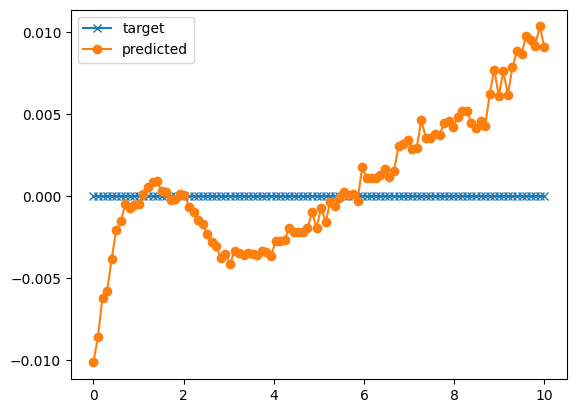

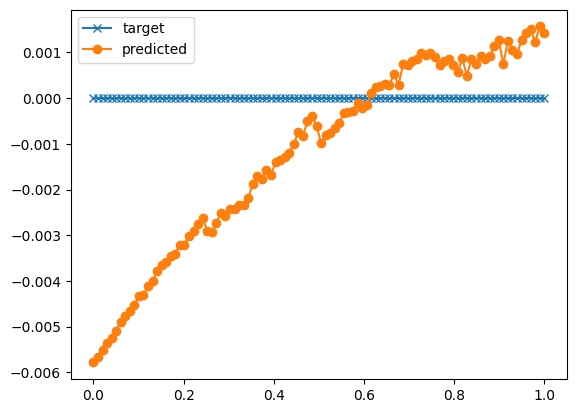

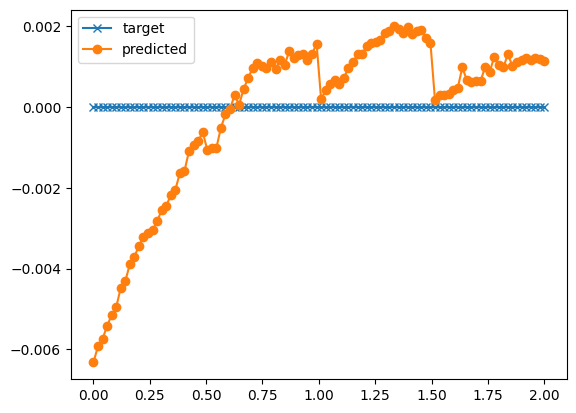

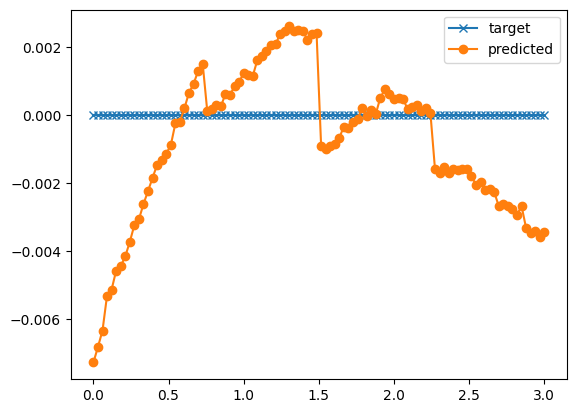

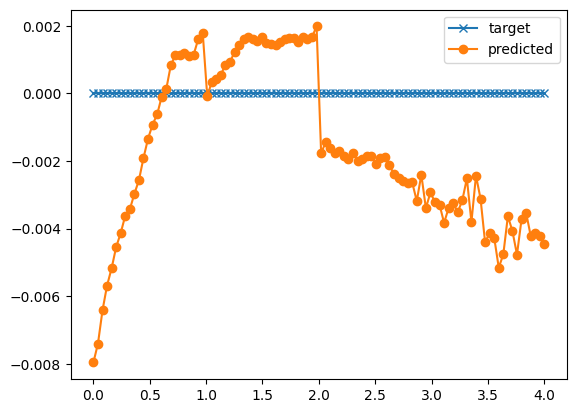

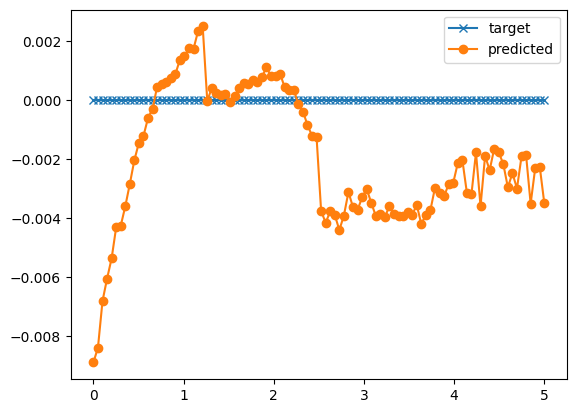

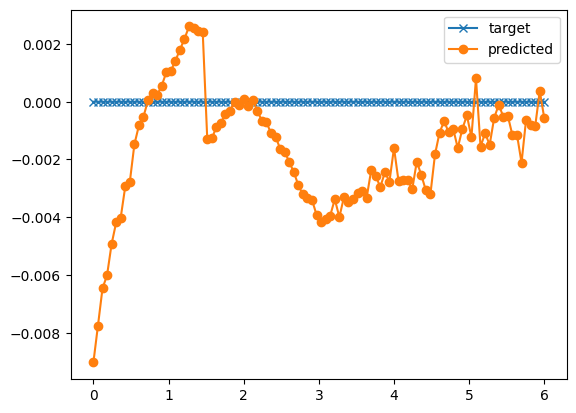

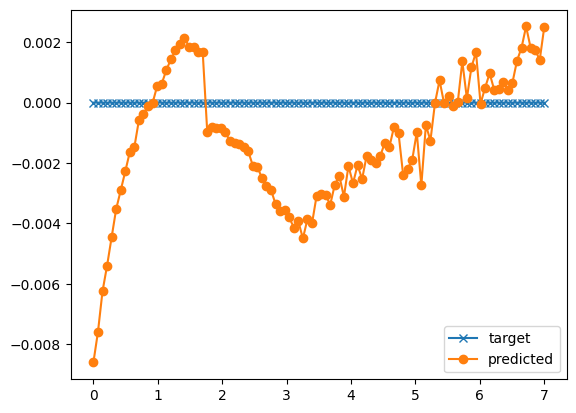

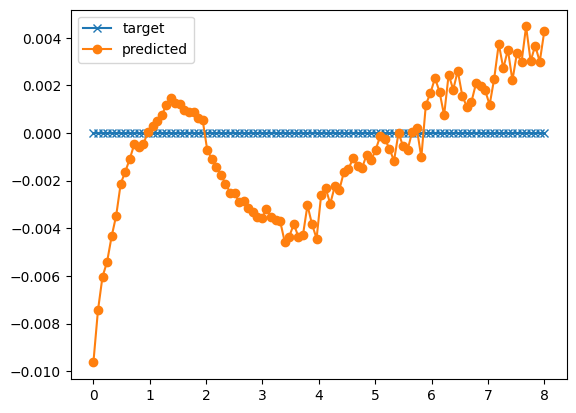

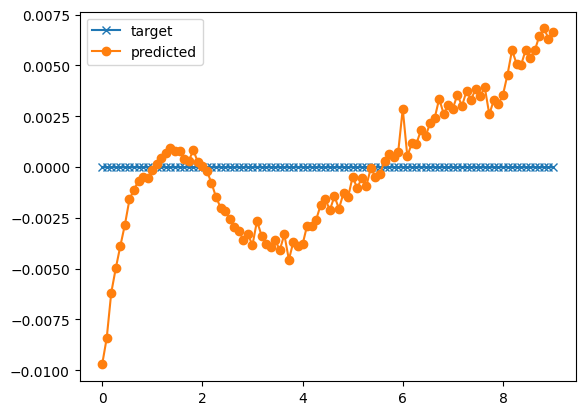

In [325]:
plot_results(simulator, test_dataloader)